In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from numpy import linalg as LA

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

SEED = 698
torch.manual_seed(SEED)

In [3]:
# Example parameters
N = 50 # Number of strings
d = 10000 # Sequence length

#Max Kernel size
M = 2

num_kernels = 20 # Number of kernels per size
BATCH_SIZE = 16
Lr = 0.1
num_epochs = 200 # Number of epochs

#Cat=(0,-1,1,2) #Regular
Cat=(2,1,1,1) #Chaotic

In [4]:
def check_point(x, y):
    if 0 <= x <= 1/2 and 0 <= y <= 1/2:
        return 1  
    
    if 1/2 <= x <= 1 and 1/2 <= y <= 1:
        return 1
    
    else:
        return 0 
    

def arnold_cat_map_DATA(length,N,Cat):
    
    
    strings=torch.zeros((N,length))
    
    
    # Perform iterations of the map
    for i in range(N):
        
        (x0,y0) = torch.tensor((0,0))+ 0.5 * torch.rand(2)
        #(x0,y0) = torch.rand(2)
        
        a=Cat[0]
        b=Cat[1]
        c=Cat[2]
        d=Cat[3]
        
        for l in range(length):
            
            #(x,y) = ((a * x0 + b * y0) % r, (c * x0 + d * y0) % r) # x%n is the reminder  of x/n
            (x,y) = ((a * x0 + b * y0) % 1, (c * x0 + d * y0) % 1) # x%1 is the reminder 1  of x
            
            
            strings[i,l] = check_point(x, y)        
            
            
            x0=x
            y0=y         

    return strings

In [5]:
# Generate data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#data = arnold_cat_map_DATA(d,N,Cat).to(device)
#train_data, test_data = torch.split(data, [int(0.8 * N), N - int(0.8 * N)])

In [6]:
# Test string
data = torch.tensor([
    [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
    1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
    0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
    0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
    0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
    1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
    1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
    1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1],
]).to(device)

In [7]:
data

tensor([[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
         0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
         1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]])

Numero di 0: 45
Numero di 1: 51


torch.Size([1, 96])

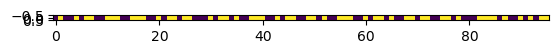

In [8]:
# Count the number of 0
num_zeros = torch.sum(data == 0).item()

# Count the number of 1
num_ones = torch.sum(data == 1).item()

print(f"Numero di 0: {num_zeros}")
print(f"Numero di 1: {num_ones}")

plt.imshow(data)
data.shape

In [9]:
class Kers(nn.Module):
    def __init__(self, max_kernel_size):

        super(Kers, self).__init__()
        self.max_kernel_size = max_kernel_size
        # Initialising a list of learnable parameters for each kernel dimension
        self.Ks = nn.ParameterList([nn.Parameter(torch.randn(size, dtype=torch.float32)) for size in range(1, max_kernel_size + 1)])
        
    def forward(self):
        eps = 1e-5
        S = [F.relu(kernel + eps) / (kernel + eps) for kernel in self.Ks]
        return S

In [10]:
class KernelModel(nn.Module):
    def __init__(self, M, num_families):
        
        super(KernelModel, self).__init__()
        self.max_kernel_size = M 
        self.kernels = nn.ModuleList([Kers(max_kernel_size=M) for _ in range(num_families)])

    def forward(self, data):
        pass

In [11]:
def ZivEntropy(binary_strings, subkernels, BATCH_SIZE):

    num_samples, sequence_length = binary_strings.size()
    num_subkernels, subkernel_size = subkernels.size()

    # Probs tensor to contain the probabilities of all sequences
    Probs = torch.zeros(num_samples, num_subkernels, dtype=torch.float32, device=subkernels.device)

    # Processing `binary_strings` in multiple batch sizes `BATCH_SIZE`
    for i in range(0, num_samples, BATCH_SIZE):
        batch_data = binary_strings[i:i + BATCH_SIZE]
        current_batch_size = batch_data.size(0)

        # Generating patches for each sequence in the current batch
        num_patches = sequence_length - subkernel_size + 1
        patches = batch_data.unfold(1, subkernel_size, 1)

        Probs_batch = torch.zeros(current_batch_size, num_subkernels, dtype=torch.float32, device=subkernels.device)
        
        for j in range(num_subkernels):
            subkernel = subkernels[j].view(1, -1)

            eps = 0.5 #***
            
            # Manhattan distance and probability calculation with Relu
            manhattan_distances = torch.abs(patches - subkernel).sum(dim=2)
            relu_distances = F.relu(eps - manhattan_distances) / eps
            Probs_batch[:, j] = relu_distances.mean(dim=1)

        Probs[i:i + current_batch_size] = Probs_batch

    #Scaled Probs
    total_sum = Probs.sum(dim=1, keepdim=True)
    Probs_scaled = torch.where(total_sum != 0, Probs / total_sum, Probs)
    print("Scaled Probs:", Probs_scaled)
    return Probs_scaled

In [12]:
def ZivEntropyLoss(data, model, BATCH_SIZE):

    entropies_by_size = []
    Kernels_list = []

    # Iterating on each subkernels dimension
    for size in range(1, model.max_kernel_size + 1):
        all_subkernels_of_size = []

        # Collect all subkernels of this size from all families
        for family_idx, kernels in enumerate(model.kernels):
            subkernels = kernels()
            # Filter and collect only subkernels of the current size
            filtered_kernels = [k for k in subkernels if k.size(0) == size]
            all_subkernels_of_size.extend(filtered_kernels)

        # Stack of subkernels by dimension as a two-dimensional tensor
        subkernels_of_size = torch.stack(all_subkernels_of_size)  # (num_subkernels, subkernel_size)
        Kernels_list.append(subkernels_of_size)

        # Processing `data` in multiple batch sizes `BATCH_SIZE`
        num_samples = data.size(0)
        entropies_for_batch = []

        for i in range(0, num_samples, BATCH_SIZE):
            # Extract the current batch
            batch_data = data[i:i + BATCH_SIZE]

            # Calculating probabilities for all subkernels of this size and batch of data
            probs = ZivEntropy(batch_data, subkernels_of_size, BATCH_SIZE)

            # Calculating of entropy for the current batch and current size
            entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1).mean()  # Media su batch corrente
            entropies_for_batch.append(entropy)

        # Average of batch entropies for this dimension
        entropies_by_size.append(torch.mean(torch.stack(entropies_for_batch)))

    # Stack of entropies to obtain a list of entropies for each dimension
    Entropies = torch.stack(entropies_by_size)
    FullEntropy = torch.mean(Entropies)  # Average of entropies as overall entropy

    return Entropies, FullEntropy, Kernels_list

In [13]:
# Initialize the model
model = KernelModel(M, num_kernels).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=Lr)

Error importing huggingface_hub.hf_api: cannot import name 'COMMON_SAFE_ASCII_CHARACTERS' from 'charset_normalizer.constant' (/Users/tommasomingrone/anaconda3/envs/ai/lib/python3.9/site-packages/charset_normalizer/constant.py)


In [14]:
# Scheduler for learning rate adjustment
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=list(range(60, num_epochs, 20)), gamma=0.25)
losses = []
l2_lambda = 5e-1 # "Encourages" model parameters to approach zero.
positive_lambda = 1e-4 # "Pushes" negative values towards positive values

# Variable to save kernels from the first epoch
initial_kernels = None

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Calculate the primary loss
    Entropies, loss, Kernels = ZivEntropyLoss(data, model, BATCH_SIZE)

    # Print the kernels of the first epoch
    if epoch == 0:
        # Clone each tensor individually inside `Kernels`
        initial_kernels = [[k.clone().detach() for k in family] for family in Kernels]
        print("Kernel in the first epoch:")
        for idx, family in enumerate(initial_kernels):
            print(f"Size {idx + 1}:")
            for k in family:
                print(k)

    # Apply L2 regularization
    l2_penalty = sum(param.pow(2.0).sum() for param in model.parameters())
    
    # Apply Positive Penalty
    positive_penalty = sum(torch.sum(F.relu(param)) for param in model.parameters())

    # Calculating the loss including all penalties
    loss_wp = loss + l2_lambda * l2_penalty + positive_lambda * positive_penalty

    # Backpropagation
    loss_wp.backward()

    # Print the loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss_wp.item()}')

    # Print gradients for debugging
    print("Gradients:")
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"Gradient of {name}: {param.grad}")
        else:
            print(f"Gradient of {name} is None.")

    # Update the parameters
    optimizer.step()

    # Append the loss to the list
    losses.append(loss_wp.item())

    # Update the learning rate
    scheduler.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss_wp.item()}')


Scaled Probs: tensor([[0.0531, 0.0531, 0.0531, 0.0469, 0.0469, 0.0469, 0.0531, 0.0531, 0.0469,
         0.0531, 0.0531, 0.0469, 0.0531, 0.0469, 0.0469, 0.0531, 0.0531, 0.0469,
         0.0469, 0.0469]], grad_fn=<WhereBackward0>)
Scaled Probs: tensor([[0.0430, 0.0547, 0.0430, 0.0547, 0.0430, 0.0313, 0.0566, 0.0547, 0.0547,
         0.0547, 0.0547, 0.0566, 0.0566, 0.0566, 0.0430, 0.0566, 0.0313, 0.0547,
         0.0566, 0.0430]], grad_fn=<WhereBackward0>)
Kernel in the first epoch:
size 1:
tensor([1.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([1.])
tensor([-0.])
tensor([-0.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
size 2:
tensor([1., 1.])
tensor([1., -0.])
tensor([1., 1.])
tensor([1., -0.])
tensor([1., 1.])
tensor([-0., -0.])
tensor([-0., 1.])
tensor([1., -0.])
tensor([1., -0.])
tensor([1., -0.])
tensor([1., -0.])
tensor([-0., 1.])
tensor([-0., 1.

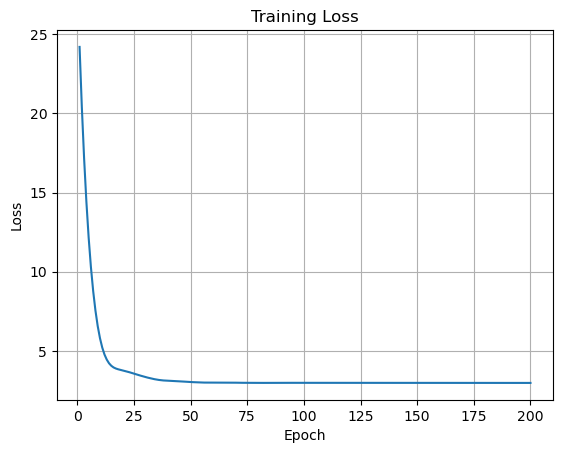

In [15]:
# %%
# Plot loss curve
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


In [16]:
# Print kernels at the latest epoch for comparison
print("\nKernel at the latest epoch:")
final_kernels = [[k.clone().detach() for k in family] for family in Kernels]
for idx, family in enumerate(final_kernels):
    print(f"Family {idx + 1}:")
    for k in family:
        print(k)

# Comparison of initial and final subkernels
print("\nComparison of initial and final SubKernels:")
for idx, (initial_family, final_family) in enumerate(zip(initial_kernels, final_kernels)):
    print(f"Family {idx + 1}:")
    for k_init, k_final in zip(initial_family, final_family):
        print(f"Initial SubKernel: {k_init}")
        print(f"Final SubKernel: {k_final}")
        print()


Kernel at the latest epoch:
Family 1:
tensor([-0.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([-0.])
tensor([1.])
tensor([-0.])
tensor([1.])
tensor([1.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
tensor([-0.])
Family 2:
tensor([1., -0.])
tensor([1., -0.])
tensor([1., 1.])
tensor([-0., -0.])
tensor([-0., -0.])
tensor([1., -0.])
tensor([1., -0.])
tensor([1., 1.])
tensor([-0., 1.])
tensor([-0., 1.])
tensor([-0., -0.])
tensor([1., 1.])
tensor([-0., -0.])
tensor([-0., -0.])
tensor([-0., -0.])
tensor([-0., -0.])
tensor([1., -0.])
tensor([-0., 1.])
tensor([-0., 1.])
tensor([-0., -0.])

Comparison of initial and final SubKernels:
Family 1:
Initial SubKernel: tensor([1.])
Final SubKernel: tensor([-0.])

Initial SubKernel: tensor([1.])
Final SubKernel: tensor([1.])

Initial SubKernel: tensor([1.])
Final SubKernel: tensor([1.])

Initial SubKernel: tensor([-0.])
Final SubKernel: tensor([-0.])

Ini

In [17]:
# %%
# Final verification of gradients after training
print("Final verification of gradients after training:")
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Gradienti di {name}: {param.grad}")
    else:
        print(f"Gradienti di {name} sono None.")


Final verification of gradients after training:
Gradienti di kernels.0.Ks.0: tensor([-0.0017])
Gradienti di kernels.0.Ks.1: tensor([ 0.0003, -0.0012])
Gradienti di kernels.1.Ks.0: tensor([-9.1706e-06])
Gradienti di kernels.1.Ks.1: tensor([-8.0140e-06, -4.9740e-05])
Gradienti di kernels.2.Ks.0: tensor([0.0002])
Gradienti di kernels.2.Ks.1: tensor([0.0243, 0.0151])
Gradienti di kernels.3.Ks.0: tensor([-0.0015])
Gradienti di kernels.3.Ks.1: tensor([-0.0066, -0.0012])
Gradienti di kernels.4.Ks.0: tensor([0.0001])
Gradienti di kernels.4.Ks.1: tensor([-0.0008, -0.0003])
Gradienti di kernels.5.Ks.0: tensor([0.0013])
Gradienti di kernels.5.Ks.1: tensor([ 0.0003, -0.0203])
Gradienti di kernels.6.Ks.0: tensor([-0.0001])
Gradienti di kernels.6.Ks.1: tensor([ 0.0006, -0.0005])
Gradienti di kernels.7.Ks.0: tensor([-4.4957e-05])
Gradienti di kernels.7.Ks.1: tensor([0.0010, 0.0001])
Gradienti di kernels.8.Ks.0: tensor([0.0004])
Gradienti di kernels.8.Ks.1: tensor([-0.0036,  0.0022])
Gradienti di kern